In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from keras.utils import to_categorical
import seaborn as sns
import keras_tuner
import scipy
# from keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch, Tuner

In [2]:
RANDOM_STATE = 42
ROWS = 48
COLUMNS = 48
BATCH_SIZE = 64
EPOCHS = 30
CLASSES = 7

### Load Data

In [3]:
files_path = "./FinalProjData"

int2emotions = {0:'angry',1:'fear',2:'happy',3:'neutral',4:'sad',5:'surprise',6:'disgust'}
emotions2int = {'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5,'disgust':6}

dic = {'images':[], 'labels':[], 'purpose':[], 'image_path':[]}

for d in os.listdir(f'{files_path}/fer2013/'):
    print(d)
    for emotion in os.listdir(f'{files_path}/fer2013/{d}'):
        print(emotion)
        for i in os.listdir(f'{files_path}/fer2013/{d}/{emotion}'):
            img = cv2.imread(f'{files_path}/fer2013/{d}/{emotion}/{i}',0)
            img = img.reshape(48,48,1)

            dic['images'].append(img)
            dic['labels'].append(emotion)
            dic['image_path'].append(f'{files_path}/fer2013/{d}/{emotion}/{i}')

            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('S')

df = pd.DataFrame(dic)
df.head()

test
angry
disgust
fear
happy
neutral
sad
surprise
train
angry
disgust
fear
happy
neutral
sad
surprise


,images,labels,purpose,image_path
0,"[[[46], [34], [26], [23], [12], [32], [35], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
1,"[[[55], [33], [54], [32], [26], [21], [50], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
2,"[[[123], [123], [126], [131], [124], [69], [10...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
3,"[[[255], [255], [255], [255], [255], [255], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
4,"[[[127], [121], [124], [137], [123], [118], [1...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...


In [4]:
train_data = df[df['purpose']=='T'].sample(frac=0.8, random_state=RANDOM_STATE)
val_data = df[df['purpose']=='T'].drop(train_data.index, axis=0)
test_data = df[df['purpose']=='S']

In [5]:
len(train_data)

22967

In [6]:
train_data['labels'].value_counts()

labels
happy       5813
neutral     3965
sad         3834
fear        3284
angry       3218
surprise    2490
disgust      363
Name: count, dtype: int64

In [7]:
val_data['labels'].value_counts()

labels
happy       1402
neutral     1000
sad          996
fear         813
angry        777
surprise     681
disgust       73
Name: count, dtype: int64

In [8]:
happy_df = train_data[train_data['labels']=='happy']
neutral_df = train_data[train_data['labels']=='neutral']
sad_df = train_data[train_data['labels']=='sad']
fear_df = train_data[train_data['labels']=='fear']
angry_df = train_data[train_data['labels']=='angry']
surprise_df = train_data[train_data['labels']=='surprise']
disgust_df = train_data[train_data['labels']=='disgust']

train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df, disgust_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,images,labels,purpose,image_path
0,"[[[5], [0], [2], [2], [4], [13], [15], [8], [1...",neutral,T,./FinalProjData/fer2013/train/neutral/Training...
1,"[[[165], [168], [168], [167], [166], [136], [8...",happy,T,./FinalProjData/fer2013/train/happy/Training_4...
2,"[[[217], [194], [204], [207], [203], [206], [1...",surprise,T,./FinalProjData/fer2013/train/surprise/Trainin...
3,"[[[99], [108], [105], [93], [101], [100], [99]...",neutral,T,./FinalProjData/fer2013/train/neutral/Training...
4,"[[[240], [171], [162], [186], [213], [222], [2...",happy,T,./FinalProjData/fer2013/train/happy/Training_2...


In [9]:
train_data['labels'].value_counts()

labels
happy       5813
neutral     3965
sad         3834
fear        3284
angry       3218
surprise    2490
disgust      363
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

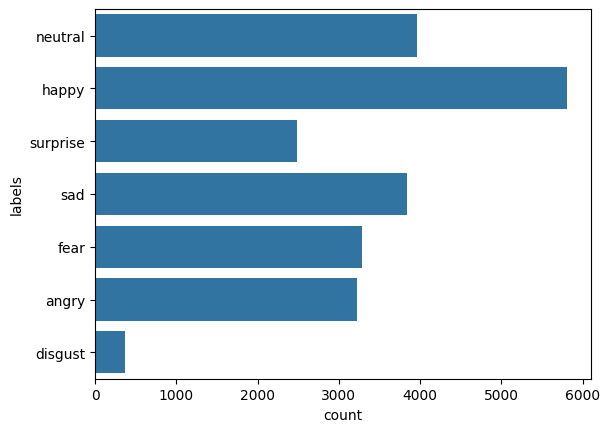

In [10]:
sns.countplot(train_data['labels'])

In [11]:
val_data['labels'].value_counts()

labels
happy       1402
neutral     1000
sad          996
fear         813
angry        777
surprise     681
disgust       73
Name: count, dtype: int64

In [12]:
# Convert dataframe to numpy array
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)

val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)

# train_data = train_data['images']
# val_data = val_data['images']

In [13]:
train_data.shape

(22967, 4)

In [14]:
val_data.shape

(5742, 4)

In [15]:
from keras.regularizers import L1L2

def create_model_name(dropout: bool, activation: str, optimizer, regularizer, loss):
    if regularizer and isinstance(regularizer, L1L2):
        regularizer='l1l2'

    optimizer = optimizer._name

    loss = loss.name

    model_name = f"dropout_{dropout}_activation_{activation}_optimizer_{optimizer}_regularizer_{regularizer}_loss_{loss}"
    return model_name


def parameterized_build_model(dropout: bool, activation: str, optimizer, regularizer, loss, input_shape: tuple,
                              classes: int):
    model = Sequential()

    # First Block
    model.add(Conv2D(64,(3,3),activation=activation,input_shape=input_shape,kernel_initializer='he_normal',
                     padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation=activation,input_shape=input_shape,kernel_initializer='he_normal',
                     padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if dropout:
        model.add(Dropout(0.2))

    # Second Block
    model.add(Conv2D(128,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
                     kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
                     kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if dropout:
        model.add(Dropout(0.2))

    # Third Block
    model.add(Conv2D(256,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
                     kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
                     kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if dropout:
        model.add(Dropout(0.2))

    # Fourth Block
    model.add(Conv2D(512,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
        kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(512,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
        kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if dropout:
        model.add(Dropout(0.2))

    # Fifth Block
    model.add(Flatten())
    model.add(Dense(256,activation=activation,kernel_initializer='he_normal', kernel_regularizer=regularizer,
                     bias_regularizer=regularizer))
    model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))

    # Sixth Block
    model.add(Dense(128,activation=activation,kernel_initializer='he_normal', kernel_regularizer=regularizer,
                     bias_regularizer=regularizer))
    model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))

    # Seventh Block
    model.add(Dense(64,activation=activation,kernel_initializer='he_normal', kernel_regularizer=regularizer,
                     bias_regularizer=regularizer))
    model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))

    # Eighth Block
    model.add(Dense(classes, activation='softmax',kernel_initializer='he_normal', kernel_regularizer=regularizer,
                    bias_regularizer=regularizer))

    model.compile(metrics=['accuracy'],
                optimizer=optimizer,
                loss=loss)

    return model


#print(model.summary())

Method for selecting the best parameters

In [23]:
from keras.optimizers import Adam, SGD
from keras.regularizers import l1_l2
from extra import CategoricalFocalCrossentropy
from keras.losses import CategoricalCrossentropy

opt_map = {
    'adam': Adam(learning_rate=0.001),
    'rmsprop': RMSprop(learning_rate=0.001),
    'sgd': SGD(learning_rate=0.001)
}

loss_map = {
    'cc': CategoricalCrossentropy(),
    'cfc': CategoricalFocalCrossentropy()
}

def build_model(hp: keras_tuner.HyperParameters):
    dropout = hp.Boolean('dropout')
    activation = hp.Choice(name='activation',values=["elu", "relu", "tanh", 'mish'])
    regularizer = hp.Choice(name='regularizer',values=['None', 'l1', 'l2'])
    optimizer = hp.Choice(name='optimizer', values=['adam', 'rmsprop', 'sgd'])
    loss = hp.Choice(name='loss',values=['cc','cfc'])

    # A workaround for not using regularizer
    if regularizer == 'None':
        regularizer = None

    model = parameterized_build_model(activation=activation,dropout=dropout,optimizer=opt_map[optimizer],
                                      regularizer=regularizer, loss=loss_map[loss],
                                      input_shape=(ROWS, COLUMNS, 1), classes=CLASSES)
    return model

In [24]:
# ModelCheckpoint(f'{files_path}/model/7_class_emotion_detector_{model_name}.h5',
#                      save_best_only=True,
#                      mode='min',
#                      monitor='val_loss',
#                      verbose=1)

def run_model(tuner: Tuner, train_data: pd.DataFrame, val_data: pd.DataFrame, epochs: int,
              batch_size: int):
    callbacks = [
        EarlyStopping(patience=10, verbose=1, min_delta=0, monitor='val_loss', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001),
        TensorBoard(log_dir="logs/tb_logs")
    ]
    # Data Augmentation setup for training data
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Data generator for validation data (No augmentation)
    val_datagen = ImageDataGenerator()

    # Create generators to read images from dataframe
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=None,  # Directory is None since paths are absolute
        x_col='image_path',
        y_col='labels',
        target_size=(48, 48),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=None,
        x_col='image_path',
        y_col='labels',
        target_size=(48, 48),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False)

    train_samples = len(train_data)
    validation_samples = len(val_data)

    # Training the model using generators
    tuner.search(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,
        callbacks=callbacks)
    return tuner

In [25]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory="logs/tb"
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
dropout (Boolean)
{'default': False, 'conditions': []}
activation (Choice)
{'default': 'elu', 'conditions': [], 'values': ['elu', 'relu', 'tanh', 'mish'], 'ordered': False}
regularizer (Choice)
{'default': 'None', 'conditions': [], 'values': ['None', 'l1', 'l2'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}
loss (Choice)
{'default': 'cc', 'conditions': [], 'values': ['cc', 'cfc'], 'ordered': False}


In [26]:
run_model(tuner, train_data, val_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Found 22967 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
True              |True              |dropout
elu               |elu               |activation
l2                |l2                |regularizer
adam              |adam              |optimizer
cfc               |cfc               |loss

Epoch 1/30
358/358 [==============================] - 25s 63ms/step - loss: 9.4668 - accuracy: 0.1802 - val_loss: 1.1518 - val_accuracy: 0.2461 - lr: 0.0010
Epoch 2/30
358/358 [==============================] - 22s 62ms/step - loss: 0.7368 - accuracy: 0.2245 - val_loss: 0.5067 - val_accuracy: 0.2461 - lr: 0.0010
Epoch 3/30
358/358 [==============================] - 22s 61ms/step - loss: 0.4248 - accuracy: 0.2447 - val_loss: 0.3842 - val_accuracy: 0.2461 - lr: 0.0010
Epoch 4/30
358/358 [==============================] - 21s 59ms/step - loss: 0.3681 - accu

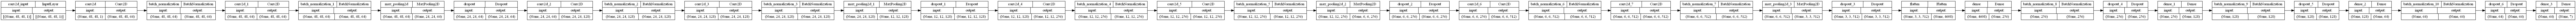

In [ ]:
# from keras.utils import plot_model
# import IPython.display


# # Plot and save the model graph
# plot_model(model, show_shapes=True, to_file='model_graph.png', rankdir='LR')
# IPython.display.Image('model_graph.png')

<Axes: >

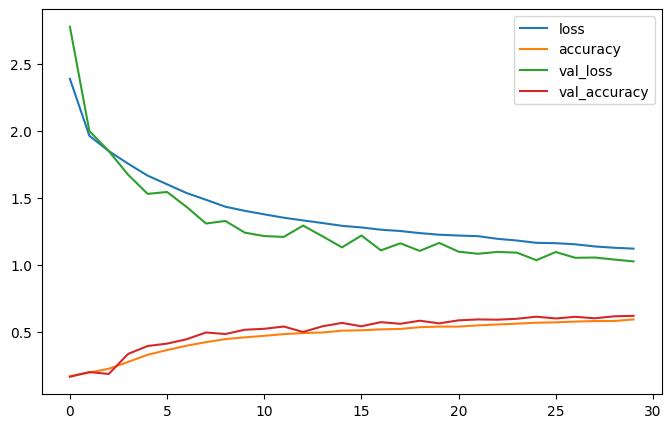

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [ ]:
import cv2
from keras.models import load_model
import numpy as np

int2emotions = {0:'angry',1:'fear',2:'happy',3:'neutral',4:'sad',5:'surprise',6:'disgust'}
model = load_model(f'{files_path}\model\\6_class_emotion_detector_V2.h5')

classifier = cv2.CascadeClassifier(f'{files_path}\Haarcascades\\haarcascade_frontalface_default.xml')

def detect_face(frame):
    faces=classifier.detectMultiScale(frame,1.3,4)
    if len(faces) == 0:
        return frame
    for x,y,w,h in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(172,42,251),2)
        face = frame[y:y+h,x:x+w]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face,(48,48))
        face = face.reshape(1,48,48,1)
        cv2.putText(frame,text=int2emotions[np.argmax(model.predict(face))],
                    org=(x,y-15),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(106,40,243),thickness=2)
    return frame

In [ ]:
cap = cv2.VideoCapture(0)

while 1:
    ret,frame= cap.read()
    if ret==True:
        cv2.imshow('emotion_detector',detect_face(frame))
        if cv2.waitKey(1)==27:
            break
cap.release()
cv2.destroyAllWindows()